In [58]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random
# Load data
training_data = pd.read_csv('../data/processed/training_prices.csv', index_col='Date', parse_dates=True)
days_trading = 252
r = 0.05245  # risk-free rate

In [61]:
heston_params = pd.DataFrame(index=data.columns, columns=['S0', 'V0', 'kappa', 'theta', 'sigma', 'rho'])
heston_params['S0'] = training_data.iloc[0,:]
log_returns = np.log(training_data / training_data.shift(1))
V0 = log_returns.var()
heston_params['V0'] = V0
heston_params

,S0,V0,kappa,theta,sigma,rho
AAPL,124.216293,0.000157,NaN,NaN,NaN,NaN
AMZN,85.820000,0.000430,NaN,NaN,NaN,NaN
EEM,37.219028,0.000095,NaN,NaN,NaN,NaN
GLD,171.059998,0.000071,NaN,NaN,NaN,NaN
JNJ,171.638855,0.000108,NaN,NaN,NaN,NaN
JPM,129.648483,0.000171,NaN,NaN,NaN,NaN
SPY,373.956818,0.000068,NaN,NaN,NaN,NaN
TSLA,108.099998,0.001089,NaN,NaN,NaN,NaN


In [67]:
def heston_variance(params, T, dt, V0):
    kappa, theta, sigma, rho = params
    variances = np.zeros(T)
    variances[0] = V0
    for t in range(1, T):
        # Euler-Maruyama method to simulate variance path
        dW = np.sqrt(dt) * np.random.normal()
        dV = kappa * (theta - variances[t-1]) * dt + sigma * np.sqrt(variances[t-1]) * dW
        variances[t] = variances[t-1] + dV
    return variances

def regularization_terms(params, lambda_reg=0.02):
    kappa, theta, sigma, rho = params
    # L2 regularization for all parameters
    l2_penalty = lambda_reg * (kappa**2 + theta**2 + sigma**2 + rho**2)
    return l2_penalty

def objective_function(params, historical_variances, T, dt, V0):
    model_variances = heston_variance(params, T, dt, V0)
    # Ensure that the sum of squared errors is appropriately scaled or modified to be sensitive to all parameters
    errors = historical_variances - model_variances
    return np.sum(errors**2) + regularization_terms(params)

def estimate_heston_params(data, stock_name):
    returns = np.log(data[stock_name] / data[stock_name].shift(1)).dropna()
    historical_variances = returns.rolling(window=30).var().dropna()

    T = len(historical_variances)
    dt = 1/252  # assuming daily data, 252 trading days in a year
    V0 = historical_variances.iloc[0]  # initial variance estimate from the first available data point

    # Initial parameter guesses: kappa, theta, sigma, rho
    initial_params = [0.5, historical_variances.mean(), 0.2, -0.5]
    bounds = [(0.01, 2), (0.0001, 0.01), (0.01, 1), (-1, 1)]

    result = minimize(objective_function, initial_params,
                      args=(historical_variances.values, T, dt, V0),
                      bounds=bounds, method='L-BFGS-B')

    return result.x

for col in heston_params.index:
    estimated_params = estimate_heston_params(data, col)
    heston_params.loc[col, "kappa":] = estimated_params

heston_params

/var/folders/5z/hnzbd1t12n77xf3htrhz93100000gn/T/ipykernel_26315/1446423359.py:8: RuntimeWarning: invalid value encountered in sqrt
  dV = kappa * (theta - variances[t-1]) * dt + sigma * np.sqrt(variances[t-1]) * dW
/var/folders/5z/hnzbd1t12n77xf3htrhz93100000gn/T/ipykernel_26315/1446423359.py:8: RuntimeWarning: invalid value encountered in sqrt
  dV = kappa * (theta - variances[t-1]) * dt + sigma * np.sqrt(variances[t-1]) * dW
/var/folders/5z/hnzbd1t12n77xf3htrhz93100000gn/T/ipykernel_26315/1446423359.py:8: RuntimeWarning: invalid value encountered in sqrt
  dV = kappa * (theta - variances[t-1]) * dt + sigma * np.sqrt(variances[t-1]) * dW
/var/folders/5z/hnzbd1t12n77xf3htrhz93100000gn/T/ipykernel_26315/1446423359.py:8: RuntimeWarning: invalid value encountered in sqrt
  dV = kappa * (theta - variances[t-1]) * dt + sigma * np.sqrt(variances[t-1]) * dW
/var/folders/5z/hnzbd1t12n77xf3htrhz93100000gn/T/ipykernel_26315/1446423359.py:8: RuntimeWarning: invalid value encountered in sqrt
  dV

,S0,V0,kappa,theta,sigma,rho
AAPL,124.216293,0.000157,0.5,0.000142,0.2,-0.5
AMZN,85.820000,0.000430,0.5,0.00036,0.2,-0.5
EEM,37.219028,0.000095,0.5,0.0001,0.2,-0.5
GLD,171.059998,0.000071,0.5,0.0001,0.2,-0.5
JNJ,171.638855,0.000108,0.5,0.0001,0.2,-0.5
JPM,129.648483,0.000171,0.5,0.0001,0.2,-0.5
SPY,373.956818,0.000068,0.5,0.0001,0.2,-0.5
TSLA,108.099998,0.001089,0.5,0.000894,0.2,-0.5


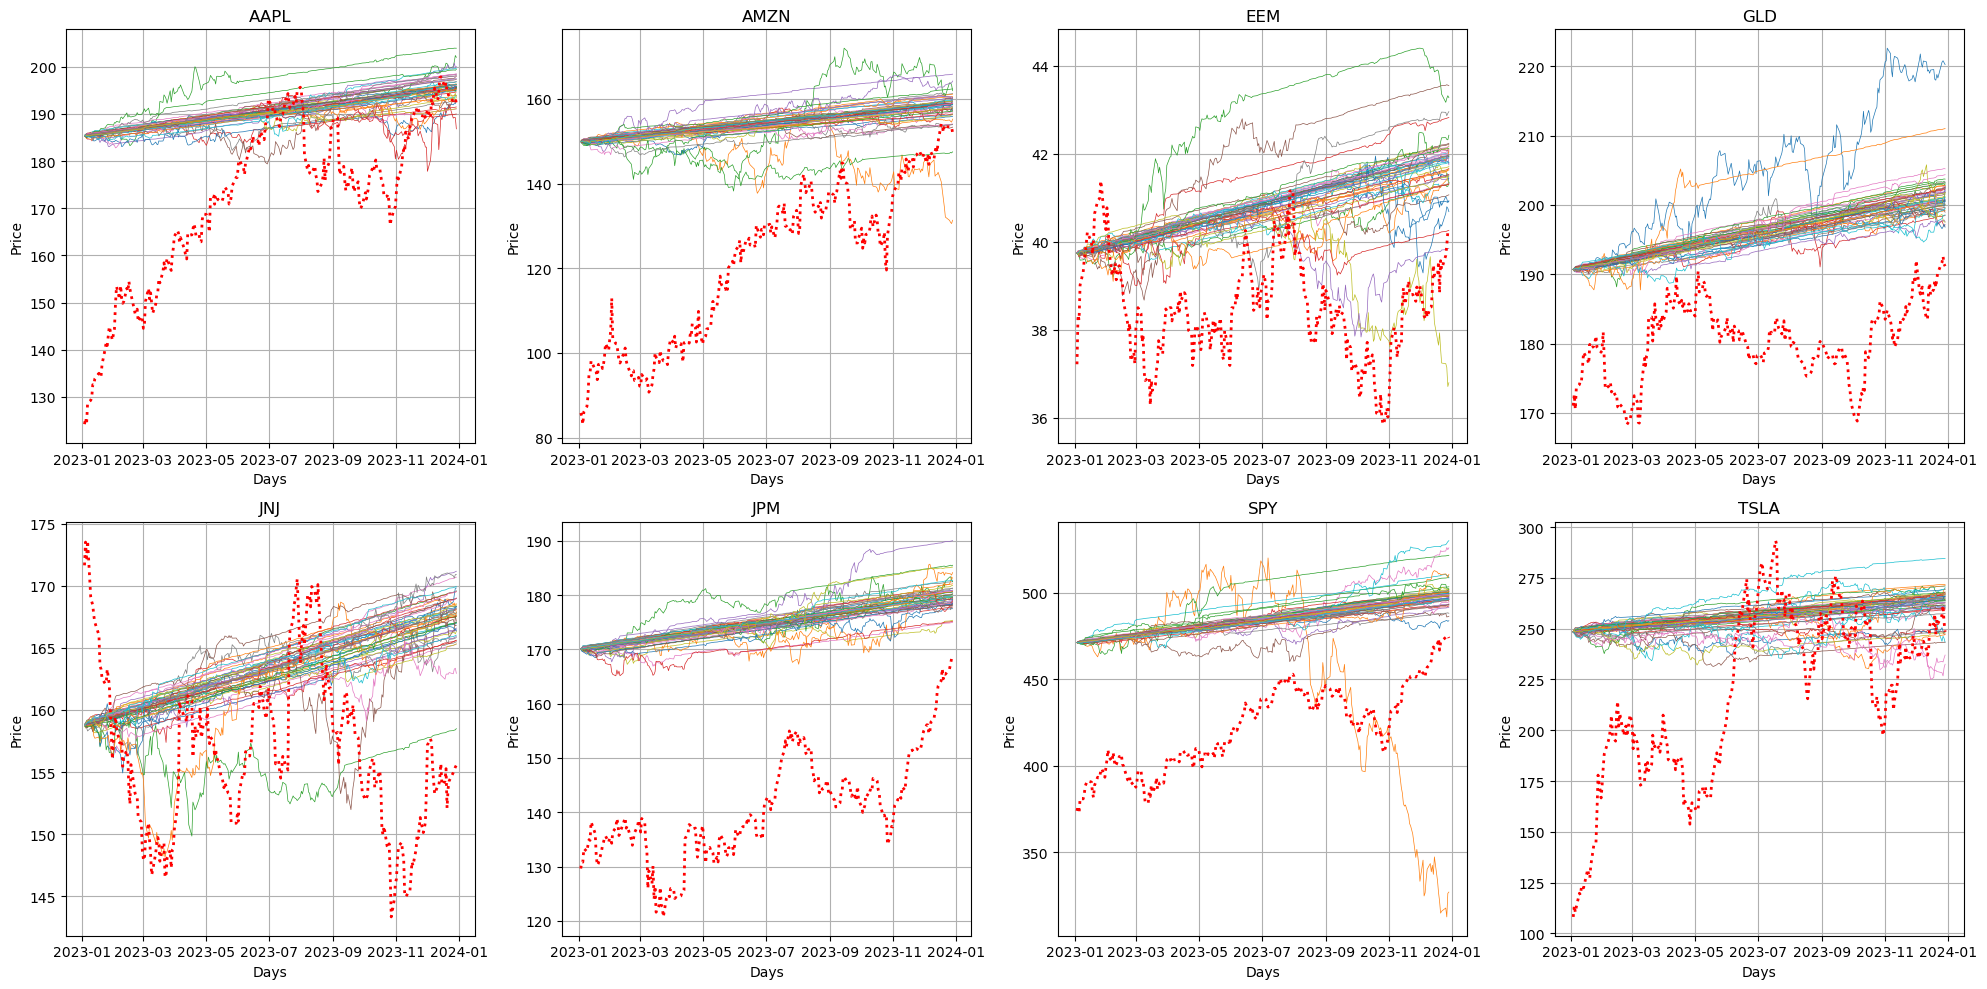

In [86]:
def heston_model_simulation(S0, V0, kappa, theta, sigma, rho, r, T=1, steps=250, Npaths=50):
    dt = T / steps
    prices = np.zeros((steps, Npaths))
    variances = np.zeros((steps, Npaths))
    prices[0, :] = S0
    variances[0, :] = V0

    for t in range(1, steps):
        dw_price = np.random.normal(size=Npaths) * np.sqrt(dt)
        dw_variance = np.random.normal(size=Npaths) * np.sqrt(dt)

        # Correlating the two Brownian motions
        dw_price = rho * dw_variance + np.sqrt(1 - rho**2) * dw_price

        # Update variance and price paths
        variances[t, :] = np.maximum(variances[t-1, :] + kappa * (theta - variances[t-1, :]) * dt + sigma * np.sqrt(variances[t-1, :]) * dw_variance, 0)
        prices[t, :] = prices[t-1, :] * np.exp((r - 0.5 * variances[t-1, :]) * dt + np.sqrt(variances[t-1, :]) * dw_price)

    return prices


# Example simulation for AAPL
r = 0.05245  # Risk-free rate
stock_names = training_data.columns
n_stocks = len(stock_names)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for i, stock_name in enumerate(stock_names):
    params = heston_params.loc[stock_name]
    simulated_prices = heston_model_simulation(params['S0'], params['V0'], params['kappa'], params['theta'], params['sigma'], params['rho'], r)
#     # Calculate row and column index for the current plot
    row = i // 4
    col = i % 4

    # Plotting on the selected subplot
    ax = axes[row, col]  # Select the appropriate subplot
    for path in range(simulated_prices.shape[1]):
        ax.plot(training_data[stock_name].index, simulated_prices[:, path], linewidth=0.5)
    ax.plot(training_data[stock_name], linewidth=2, linestyle=':', color='red')

    ax.set_title(f'{stock_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.grid(True)

# Adjust the layout so titles and labels don't overlap
plt.tight_layout()
plt.show()

## Validation

In [87]:
stock_selected = ['EEM', 'GLD']
validation_data = pd.read_csv('../data/processed/validation_prices.csv', index_col='Date', parse_dates=True)

In [88]:
heston_params_validation = heston_params
heston_params_validation['S0'] = validation_data.iloc[0,:]
df_simulated_paths = pd.DataFrame(columns=stock_selected)

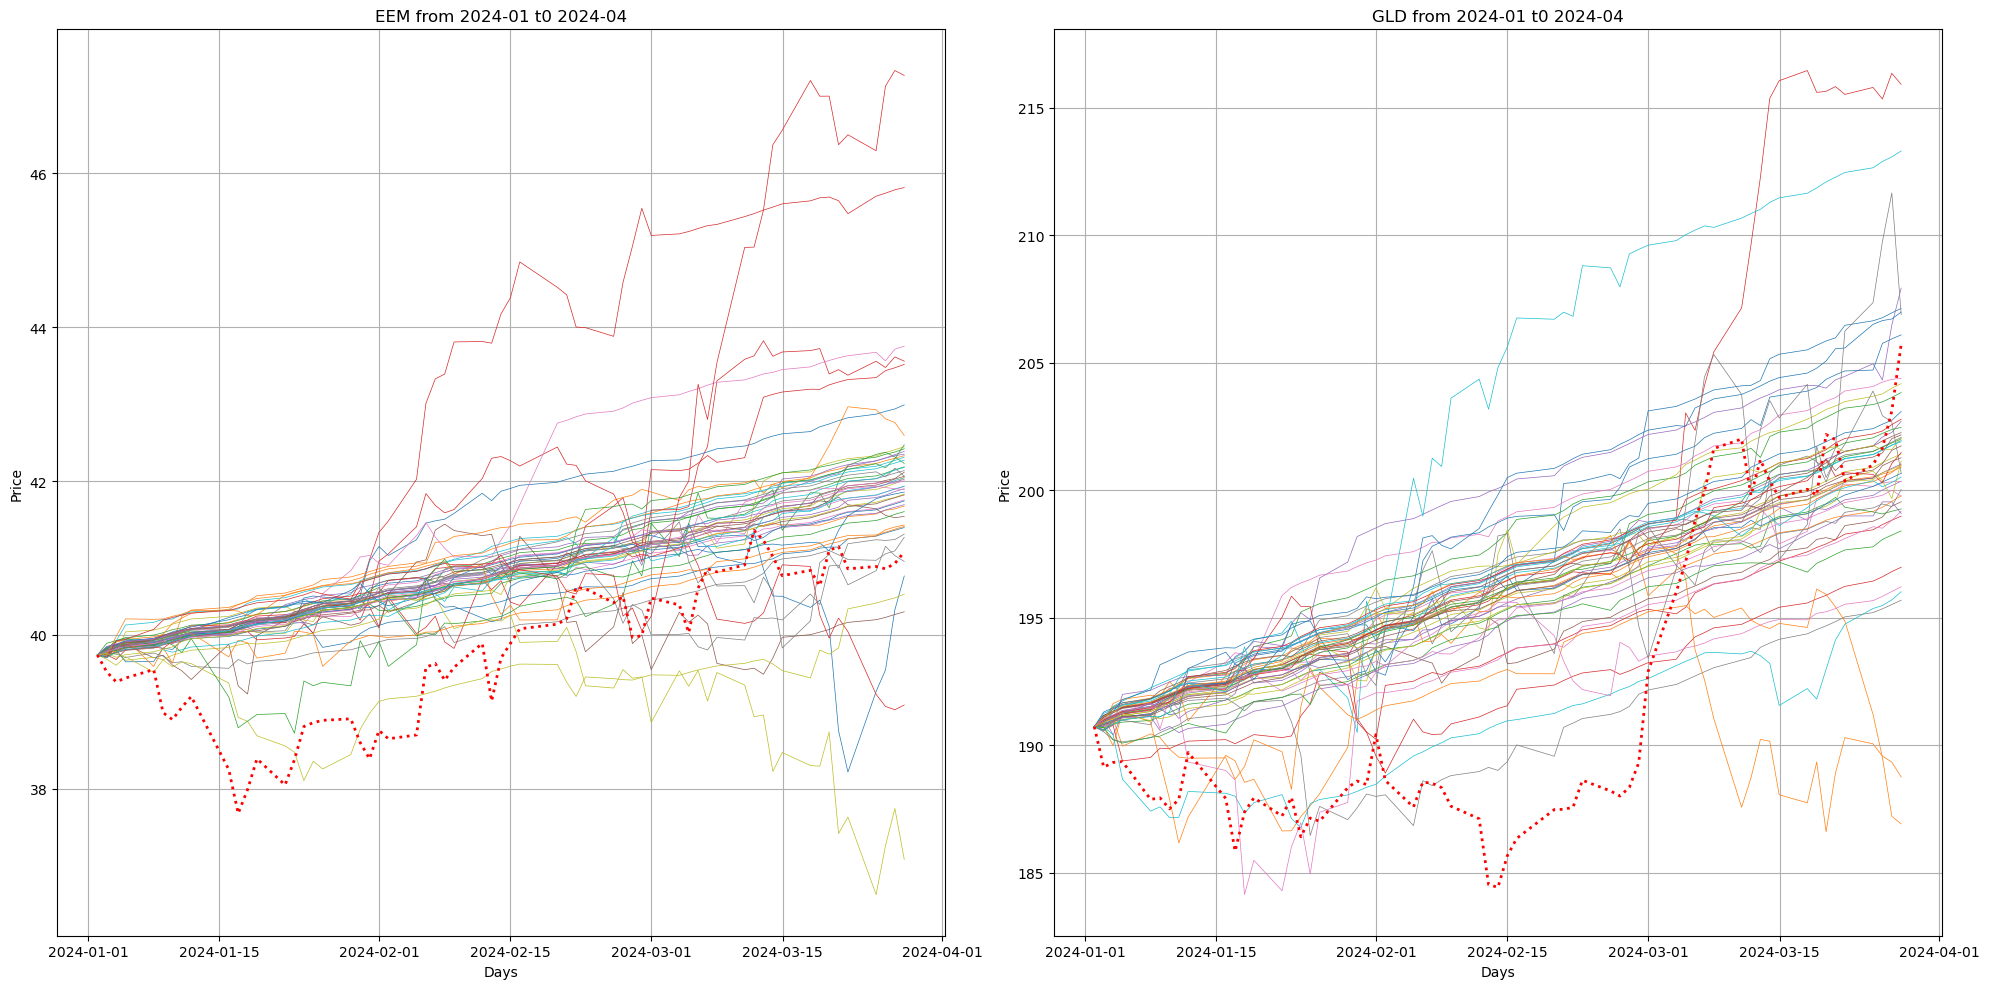

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
for i, stock in enumerate(stock_selected):
    params = heston_params.loc[stock]
    simulated_prices = heston_model_simulation(params['S0'], params['V0'], params['kappa'], params['theta'], params['sigma'], params['rho'], r, steps=61)
    col = i % 2
    ax = axes[col]  # Select the appropriate subplot
    for path in range(simulated_prices.shape[1]):
        ax.plot(validation_data[stock].index, simulated_prices[:, path], linewidth=0.5)
    # randomly pick a path and add it to df
    random_path = simulated_prices[:, np.random.choice(simulated_prices.shape[1])]
    df_simulated_paths[stock] = random_path
    ax.plot(validation_data[stock], linewidth=2, linestyle=':', color='red')
    ax.set_title(f'{stock} from 2024-01 t0 2024-04')
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.grid(True)

# Adjust the layout so titles and labels don't overlap
plt.tight_layout()
plt.show()

In [93]:
df_simulated_paths.index = validation_data.index
df_simulated_paths.to_csv('../data/processed/simulated_prices_heston.csv')